In [ ]:
# might need to run this next line and restart the session for for it to work on Colab
# !pip install matplotlib --upgrade

from google.colab import drive
drive.mount('/content/drive')

# path where the data is contained
path = '/content/drive/MyDrive/IHLT/lab2/'

import pandas as pd
import re
import nltk
from nltk.metrics import jaccard_distance
from nltk.stem import PorterStemmer
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np 
from IPython.display import display_html 

nltk.download('stopwords')
nltk.download('punkt')

Authors:
* Benjamí Parellada 
* Clara Rivadulla
# Lab 2

For the second practical of the subject, the goal is to compare the similarity between pairs of sentences using `nltk` and learning how to tokenize using `punkt`. The steps this notebook does are:

1. Read all pairs of sentences of the SMTeuroparl files.
2. Process the sentences and convert them to tokens. Use the preprocessing done in the first lab (convert to lowercase, remove stop words, etc.).
3. Compute the similarities between sentences with the Jaccard distance.
4. Compute the Pearson Correlation between the Jaccard Distance and the Golden Standard given to us.
5. Analyze the results.
6. Conclusions.

We begin by importing the necessary packages and initialize the regex, stemmer and creating a set of the stopwords to be able to preprocess the sentences.

In [ ]:
ps = PorterStemmer()
stopw = set(nltk.corpus.stopwords.words('english')) # english stopwords
regex = re.compile(r'\W+') # regex of only alphabetical characters

We define a function, `text_preprocessing`, which will be used each time we want to pre-process a sentence represented by a string, the function will return the preprocessed tokens of the sentence. Basically, it discards its stopwords and all of its non-alphabetical symbols and characters, while also stemming the word and converting them to lowercase. It returns a `set` containing the desired filtered tokens.

The stemmer basically reduces the inflection of a word, keeping only the root. 

This function will allow us to modify it quickly without having to copy and paste much code on future lab sessions.

In [ ]:
def text_preprocessing(sentence):
  sentence = re.sub(r'[^\w\s]', '', sentence) 
  tokens = nltk.word_tokenize(sentence)
  tokens = [w.lower() for w in tokens if not w.lower() in stopw]
  tokens = [ps.stem(w) for w in tokens]
  return set(tokens)

Once all the preliminaries are done, we can read the data from the SMTeuroparl files into a pandas dataframe, `dt`. Afterwards, we can run the preprocessing on each row to convert the sentence into its respective tokenization.

The resulting data frame contains the original sentences in the first two columns, with the following two containing their resulting tokenization achieved with `text_preprocesing`. The final column contains the original gold standard value `gs` from the SMTeuroparl files.

The following is a sample of how the dataframe looks:

In [ ]:
sentences = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None)
dt = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None)
dt[2] = dt.apply(lambda row: text_preprocessing(row[0]), axis = 1)
dt[3] = dt.apply(lambda row: text_preprocessing(row[1]), axis = 1)
dt['gs'] = pd.read_csv(path + 'STS.gs.SMTeuroparl.txt', sep='\t', header = None)
dt.head()

,0,1,2,3,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,"{given, leader, let, chanc, new, seiz, us, hope}","{aujourd, leader, let, luck, new, benefit, sei...",4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,"{propos, paragraph, amend, chang, refer, 7, ce...","{propos, paragraph, amend, chang, refer, 7, ce...",5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,"{tax, alli, let, includ, support, fervent, rem...","{would, strong, alli, tax, like, remind, among}",4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,"{place, today, 530, take, pm, vote}","{530pm, place, vote, take}",4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...","{tire, inact, disappoint, fishermen}","{tire, inact, disappoint, fishermen}",5.00


Once we get the tokens for each sentence, we can compute the Jaccard similarity for each pair of sentences (column 2 and column 3 of each row of the dataframe `dt`). 

The `nltk` function used is `jaccard_distance` gives us the **distance** between both sentences, while we are interested in the **similarity**. By using the distance, when two sets are similar we get a value closer to 0, meanwhile when they are more distinct we get a value closer to 1. This is different from how the gold standard is in the dataset, similar sentences have higher values, and dissimilar sentences have lower values.

Hence, this is why we use the similarity, which is the inverse of the distance, and we can calculate it as such:

$$similarity_{jaccard} = 1 - distance_{jaccard}$$

This will return a value which emulates the gold standard, and hopefully our results should linearly correlate with the gold standard. 

To make the comparison easier, the similarity is bound between [0, 1] and the gold standard between [0, 5], thus we multiply by 5 the similarity to obtain values easier to humanly compare. This change does not affect the linear correlation.

In [ ]:
dt['jac'] = dt.apply(lambda row: 5*(1 - jaccard_distance(row[2], row[3])), axis = 1)
dt.head()

,0,1,2,3,gs,jac
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,"{given, leader, let, chanc, new, seiz, us, hope}","{aujourd, leader, let, luck, new, benefit, sei...",4.50,1.538462
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,"{propos, paragraph, amend, chang, refer, 7, ce...","{propos, paragraph, amend, chang, refer, 7, ce...",5.00,5.000000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,"{tax, alli, let, includ, support, fervent, rem...","{would, strong, alli, tax, like, remind, among}",4.25,1.363636
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,"{place, today, 530, take, pm, vote}","{530pm, place, vote, take}",4.50,2.142857
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...","{tire, inact, disappoint, fishermen}","{tire, inact, disappoint, fishermen}",5.00,5.000000


Finally, we calculate the Pearson correlation for all pairs of sentences with the gold standards given and the Jaccard similarities previously computed. 

The value obtained is not very high, and if we remove stemming from the preprocessing it reaches around 0.468 which is a bit disappointing due to us believing it would make a stark difference. Since we are comparing sets of words instead of string by string (for example using the Hamming distance of each word), the sentence similarity boils down to if the word is contained in the set or not. Hence, we keep the stemming since we think it makes sense to stem the words to compare sets, even though it returns a bit worse Pearson correlation.

In [ ]:
pearsonr(dt['gs'], dt['jac'])[0]

0.46204717181859406

## Analyzing the results

After seeing this low correlation, let us check to see why or how we could improve it. 

First, we plot a scatterplot of the gold standard vs our results with the Jaccard similarity to see how if the relationship looks linear. Observing the graph, we can clearly see that the gold standard usually returns higher values than our method. We can say this due to the fact that most points fall below the standard 1:1 slope line. In other words, this result shows that most sentences considered very similar by the GS are not considered that similar by our method.

However, the relationship between the GS and our method does seem linear when a linear model is fitted to the data, we can see it is clearly parallel to the 1:1 slope, but with the offset negatively biased.

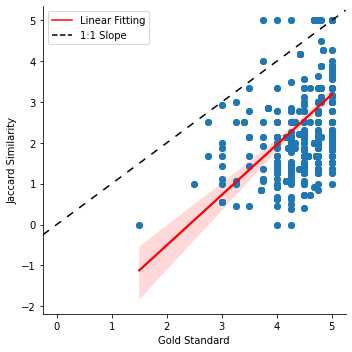

In [ ]:
sns.lmplot(x = 'gs', y = 'jac', data = dt, line_kws = {'color': 'red'});
plt.scatter(dt['gs'], dt['jac'])
plt.xlabel("Gold Standard")
plt.ylabel("Jaccard Similarity")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
ols = mlines.Line2D([], [], color='red', label='Linear Fitting')
lin = mlines.Line2D([], [], color='black', linestyle='--', label='1:1 Slope')
plt.legend(loc='upper left', handles = [ols, lin] )
plt.show()

While interesting, let us look at something more riveting: the sentences that have the highest difference between the gold standard and to our method. We compute it the difference of both values by doing:

$$diff = |similarity_{jaccard} - gold\_standard| $$

Looking at the results, we can clearly see why the pair 452 fails. While the sentences are clearly similar in meaning, they do not share the same words. Hence, our dumb comparison of only checking if a sentence is the same if they contain the same words will never work. 

We can see this trend on the next examples as well, while the sentences are similar, some words are different, making the naive approach fail.

In [ ]:
dt['diff'] = abs(dt['jac'] - dt['gs'])
dt_worst = dt.sort_values(by=['diff'], ascending=False).head(5)

In [ ]:
df1_styler = dt_worst.style.set_table_attributes("style='display:inline'").set_caption('Highest difference between Jaccard and Gold Standard')
display_html(df1_styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac,diff
452,Then perhaps we could have avoided a catastrophe.,We might have been able to prevent a disaster.,"{'perhap', 'catastroph', 'could', 'avoid'}","{'abl', 'disast', 'might', 'prevent'}",4.250000,0.000000,4.250000
236,I am one of those Members who attends sittings quite faithfully.,I form part of the members of Parliament who are rather honourably present.,"{'attend', 'sit', 'quit', 'member', 'faith', 'one'}","{'present', 'form', 'part', 'rather', 'parliament', 'member', 'honour'}",4.500000,0.416667,4.083333
212,I am one of those Members who attends sittings quite faithfully.,I am part of parliamentarians who are rather present honourably.,"{'attend', 'sit', 'quit', 'member', 'faith', 'one'}","{'present', 'parliamentarian', 'part', 'rather', 'honour'}",4.000000,0.000000,4.000000
323,The European Union has got to do something and do it quickly.,It is necessary that the European Union gets involved and that it makes it fast.,"{'quickli', 'got', 'union', 'someth', 'european'}","{'union', 'necessari', 'fast', 'get', 'involv', 'make', 'european'}",5.000000,1.000000,4.000000
415,Let me remind you that our allies include fervent supporters of this tax.,"I make a point of recalling you that among our allies, there are enthusiasts of this tax.","{'tax', 'alli', 'let', 'includ', 'support', 'fervent', 'remind'}","{'tax', 'alli', 'point', 'make', 'recal', 'enthusiast', 'among'}",4.750000,0.833333,3.916667


We know that our method will be bad when sentences do not share the same words, let us check now what are the worst Gold Standard sentences to learn where its faults are.

While pair 295 clearly does not seem to be very similar in meaning, pair 392 do seem quite similar and the GS retuned a pretty bad result. It seems that using more complex words, e.g., Commissioner vs Police Chief, pontificate vs represent, seems to confuse the GS. Also, pair 383 seems to indicate that the GS gives importance to numbers, otherwise we think it would return a very high value.

In [ ]:
dt_gs_lower = dt.sort_values(by=['gs']).head(5)

In [ ]:
df4_styler = dt_gs_lower.style.set_table_attributes("style='display:inline'").set_caption('Lowest gold standard values')
display_html(df4_styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac,diff
295,That provision could open the door wide to arbitrariness.,This paves the way for the of the Rules of Procedure here.,"{'open', 'wide', 'could', 'arbitrari', 'door', 'provis'}","{'pave', 'rule', 'way', 'procedur'}",1.500000,0.000000,1.500000
392,"Thank you, Commissioner.","Thank you, Mister the Police chief.","{'thank', 'commission'}","{'thank', 'polic', 'chief', 'mister'}",2.500000,1.000000,1.500000
375,We often pontificate here about being the representatives of the citizens of Europe.,We are often here to represent the European citizens.,"{'europ', 'repres', 'often', 'pontif', 'citizen'}","{'citizen', 'repres', 'european', 'often'}",2.750000,2.500000,0.250000
383,Maij-Weggen report (A5-0323/2000),Mrs Maij-Weggen's report (5 / 2000),"{'report', 'a503232000', 'maijweggen'}","{'mr', '5', 'maijweggen', 'report', '2000'}",2.750000,1.666667,1.083333
80,I am one of those Members who attends sittings quite faithfully.,I am part of Members who are not properly present.,"{'attend', 'sit', 'quit', 'member', 'faith', 'one'}","{'member', 'present', 'part', 'properli'}",3.000000,0.555556,2.444444


## Conclusions
In conclusion, we get a Pearson correlation of `0.46204717181859406`, which means that there is still room for improvement for our sentence similarity algorithm with the gold standard of 2012. We already detected some faults with the naïveness of the algorithm, as checking only if the sets of words in a sentence match can be detrimental when synonyms are used.

The main takeaway is that we need to add more complexity to our method, for example by having a dictionary of synonyms to also check if the words are similar. This should return us a value closer to the gold standard, as we previously observed it was where our method was lacking.

Finally, we did not present it in the document, but we did some testing, and it is quite important to take careful consideration of the preprocessing steps. Some other observations:

 - Not removing the stopwords increases the correlation as expected. Since stopwords are usually the most common parts of a language, not removing them will seem our sentences are closer than they really are.
 - The order of regex and processing is very important. For example, we tested changing where we removed the punctuation signs, and removing them before the tokenization improved the results of the correlation more than removing them afterwards. 


